**Dynamic KNN Outlier Detection:**
The code applies KNN to detect outliers in the log returns of each sector. However, instead of using a fixed number of neighbors (k), the code dynamically adjusts k based on the sector’s volatility. For sectors with higher volatility, k is increased, making the model more flexible and responsive to each sector's unique characteristics.

**Rolling Volatility and Threshold Adjustment:**
A rolling standard deviation is calculated over a defined window to measure each sector's volatility over time. This rolling volatility not only influences k but also helps set a dynamic threshold for outlier detection. This means that outliers are detected relative to the sector’s recent volatility, adapting as market conditions change.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving mid_cap_all_sectors_ret.csv to mid_cap_all_sectors_ret.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns

data = pd.read_csv('mid_cap_all_sectors_ret.csv')
sectors = data.drop(columns=['date'])
dates = pd.to_datetime(data['date'])

In [3]:
def detect_outliers_knn(data, n_neighbors, rolling_volatility):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))

    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(data_scaled)

    distances, _ = knn.kneighbors(data_scaled)

    # Adjust the threshold dynamically based on rolling volatility
    if rolling_volatility is not None:
        dynamic_thresholds = np.mean(distances) + rolling_volatility * np.std(distances)
    else:
        dynamic_thresholds = np.mean(distances) + np.std(distances)

    outliers = distances.mean(axis=1) > dynamic_thresholds
    return outliers, dynamic_thresholds


In [4]:
def calculate_mae(data):
    mae_value = mean_absolute_error(data[1:], data[:-1])
    return mae_value

In [5]:
def plot_sector_log_returns(ax, sector_name, log_returns, outliers, dates):
    # Plot log returns line
    sns.lineplot(x=dates, y=log_returns, ax=ax, label=f"{sector_name} Log Returns")
    # Highlight outliers with red markers
    outlier_indices = np.where(outliers)[0]
    sns.scatterplot(x=dates[outlier_indices], y=log_returns[outlier_indices],
                    color="red", s=50, ax=ax, label="Detected Outliers", marker="o")

    ax.set_title(f"KNN: {sector_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Log Returns")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

<ipython-input-6-0afe3409ee49>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outlier_matrix = pd.DataFrame(index=dates, columns=sectors.columns).fillna(0)


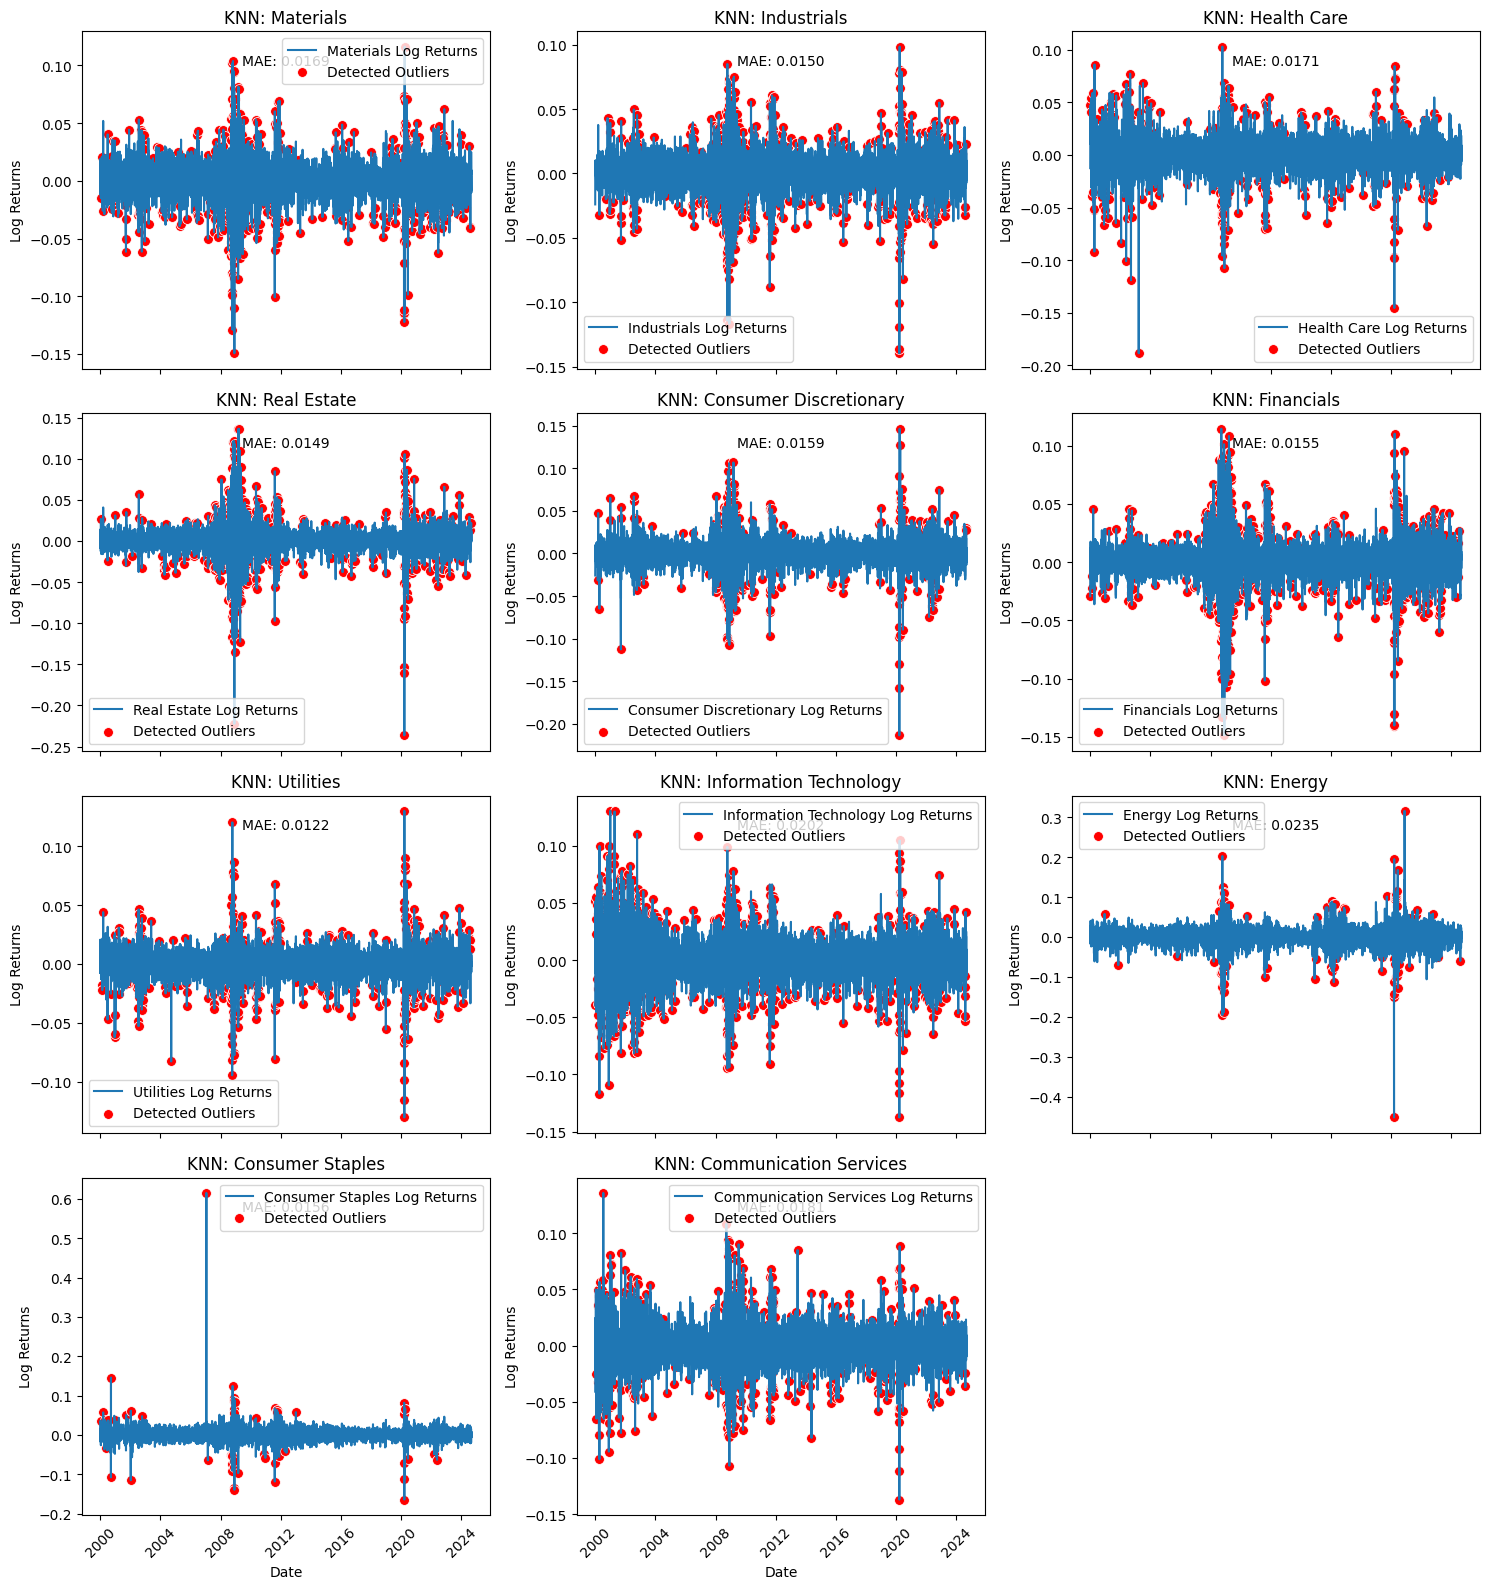

In [6]:
outlier_matrix = pd.DataFrame(index=dates, columns=sectors.columns).fillna(0)

rolling_window = 50


num_sectors = len(sectors.columns)
num_cols = 3
num_rows = (num_sectors + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows), sharex=True)
axes = axes.flatten()

for i, sector in enumerate(sectors.columns):
    log_returns = sectors[sector].values

    rolling_volatility = pd.Series(log_returns).rolling(window=rolling_window).std().fillna(0).values
    sector_volatility = np.std(log_returns)
    n_neighbors = max(2, int(10 * sector_volatility))
    outliers, dynamic_thresholds = detect_outliers_knn(log_returns, n_neighbors=n_neighbors, rolling_volatility=rolling_volatility)
    mae_value = calculate_mae(log_returns)

    outlier_indices = np.where(outliers)[0]
    outlier_dates = dates[outlier_indices]
    outlier_matrix.loc[outlier_dates, sector] = 1

    # Plot sector log returns and detected outliers
    plot_sector_log_returns(axes[i], sector, log_returns, outliers, dates)
    axes[i].text(0.5, 0.9, f"MAE: {mae_value:.4f}", transform=axes[i].transAxes, ha='center')

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [7]:
outlier_matrix

,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
date,,,,,,,,,,,
2000-01-04,0,0,0,0,0,1,0,1,0,0,0
2000-01-05,0,0,0,0,0,0,0,0,0,0,0
2000-01-06,0,0,0,0,0,0,0,0,0,0,0
2000-01-07,0,0,1,0,0,0,0,0,0,0,0
2000-01-10,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,0,0,0,0,0,0,0,0,0,0,0
2024-08-27,0,0,0,0,0,0,0,0,0,0,0
2024-08-28,0,0,0,0,0,0,0,0,0,0,0


In [8]:
filtered_outlier_matrix = outlier_matrix.loc[outlier_matrix.index > "2019-09-26"]
outlier_counts = filtered_outlier_matrix.sum(axis=0)

In [9]:
outlier_counts

,0
Materials,86
Industrials,100
Health Care,33
Real Estate,87
Consumer Discretionary,57
Financials,118
Utilities,82
Information Technology,73
Energy,29
Consumer Staples,10


In [10]:
outlier_counts.to_csv('KNN.csv', index=False)